# GPU Configuration

In [ ]:
!nvidia-smi

Sun Feb  5 12:38:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |   8220MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Importing Packages

In [ ]:
# Common Imports
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from google.colab import drive
from matplotlib.image import imread

# PyTorch Imports
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from torchsummary import summary as Summary
from torch.utils.data import Dataset, DataLoader, random_split

# Mounting Google Drive

In [ ]:
Root_Folder = "Detection_Overall"

if not os.path.isdir(f"/content/{Root_Folder}"):

    if not os.path.isdir("/content/Drive"):

        drive.mount("Drive", force_remount=True)

    ZipFile = f'/content/Drive/MyDrive/Thesis/Classifier/{Root_Folder}.zip'
    !unzip -qq {ZipFile}

#Functions

In [ ]:
def weight_initializer(module):

    if isinstance(module, nn.Conv2d):
        nn.init.xavier_normal_(module.weight)
        nn.init.constant_(module.bias, 0.001)

    elif isinstance(module, nn.Linear):
        nn.init.xavier_normal_(module.weight)
        nn.init.constant_(module.bias, 0.001)

In [ ]:
def Accuracy_Computer(Model, Dataset, Device):

    Corrects = 0
    Samples = 0
    Model.eval()

    with torch.no_grad():

        for image, label in Dataset:
            
            # Transfer Data to GPU
            image = image.to(device=Device)
            label = label.to(device=Device)

            # forward(prediction)
            label_prime = Model(image)
            _, predictions = label_prime.max(1)
            
            # determine the correct samples
            Corrects += (predictions == label).sum()
            Samples += label.shape[0]

        Accuracy =  Corrects / Samples

    return float(Accuracy)

# Classes

In [ ]:
class CNN_Model(nn.Module):
     
    def __init__(self, Input_Size, Number_of_Classes=2):
        
        super().__init__()
        Input_Channels = Input_Size[0]
        Temp_X = torch.reshape(torch.zeros(Input_Size), (1, *Input_Size))

        # Convolutional Layers
        self.Convolutional_Network = nn.Sequential(
            
            # First Layer
            nn.Conv2d(Input_Channels, 96, 7, 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Second Layer
            nn.Conv2d(96, 32, 5, 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            # Third Layer
            nn.Conv2d(32, 16, 3, 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Fourth Layer
            nn.Conv2d(16, 8, 3, 2),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )

        First_Linear_Layer_Size = self.Convolutional_Network(Temp_X).shape[1]

        # Linear Layers
        self.Linear_Network = nn.Sequential(

            # Fifth Layer
            nn.Linear(First_Linear_Layer_Size, 50),
            nn.ReLU(inplace=True),

            # Sixth Layer
            nn.Linear(50, 32),
            nn.ReLU(inplace=True),

            # Seventh Layer
            nn.Linear(32, Number_of_Classes),
            nn.Softmax(dim=1),
        )

    def forward(self, x):

        return self.Linear_Network(self.Convolutional_Network(x))

In [ ]:
class Medical_Dataset(Dataset):

    def __init__(self, root_folder, class_folders=None, XTransformer=None, YTransformer=None, 
                 Validation_Type=None, Train_Dataset=True, Validation_Subject=1):
        
        self.XTransformer = XTransformer
        self.YTransformer = YTransformer
        self.Dataset_Size = 0

        Validation_Subject = Validation_Subject - 1
         
        if not class_folders:
    
            class_folders = os.listdir(root_folder)
            class_folders.sort()

        #################### No validation measures ####################
        if not Validation_Type :

            for class_folder in class_folders:

                class_folder_path = os.path.join(root_folder, class_folder)
                self.Dataset_Size += len(os.listdir(class_folder_path))

            Total_Images = np.empty(0)
            Total_Labels = torch.zeros(self.Dataset_Size, dtype=torch.int64)
            dataset_index = 0

            # loop through each folder
            for index, class_folder in enumerate(class_folders):
                
                class_folder_path = os.path.join(root_folder, class_folder)
                images_name = os.listdir(class_folder_path)
                images_name.sort()

                # loop through each sample
                for image_name in images_name:
                    
                    Total_Images = np.append(Total_Images, os.path.join(class_folder_path, image_name))
                    Total_Labels[dataset_index] = index
                    dataset_index += 1

            permutation = np.random.permutation(np.arange(len(Total_Images)))
            
            self.images = Total_Images
            self.labels = Total_Labels

        #################### Leave One Patient Out Validation ####################

        elif Validation_Type == "LOO":

            if Train_Dataset:

                # Checking the Dataset and obtain the size of it
                for class_folder in class_folders:
                    
                    class_folder_path = os.path.join(root_folder, class_folder)
                    subject_folders = os.listdir(class_folder_path)
                    
                    if len(subject_folders) < Validation_Subject :

                        raise IndexError("validation subject does not exist")

                    del subject_folders[Validation_Subject]

                    for subject_folder in subject_folders:

                        subject_folder_path = os.path.join(class_folder_path, subject_folder)
                        self.Dataset_Size += len(os.listdir(subject_folder_path))

                # define each image path and label
                Total_Images = np.empty(0)
                Total_Labels = torch.zeros(self.Dataset_Size, dtype=torch.int64)
                dataset_index = 0
                
                # looping through class folders
                for index, class_folder in enumerate(class_folders):
                    
                    class_folder_path = os.path.join(root_folder, class_folder)
                    subject_folders = os.listdir(class_folder_path)
                    subject_folders.sort()

                    del subject_folders[Validation_Subject]

                    # looping through subjects
                    for subject_folder in subject_folders:

                        subject_folder_path = os.path.join(class_folder_path, subject_folder)
                        images_name = os.listdir(subject_folder_path)
                        images_name.sort()

                        # looping through images
                        for image_name in images_name:
                            
                            Total_Images = np.append(Total_Images, os.path.join(subject_folder_path, image_name))
                            Total_Labels[dataset_index] = index
                            dataset_index += 1

            elif not Train_Dataset:
                
                # looping through class folders
                for class_folder in class_folders:
                    
                    class_folder_path = os.path.join(root_folder, class_folder)
                    subject_folders = os.listdir(class_folder_path)
                    
                    if len(subject_folders) < Validation_Subject:

                        raise IndexError("validation subject does not exist")

                    subject_folder =  subject_folders[Validation_Subject]
                    subject_folder_path = os.path.join(class_folder_path, subject_folder)
                    self.Dataset_Size += len(os.listdir(subject_folder_path))

                Total_Images = np.empty(0)
                Total_Labels = torch.zeros(self.Dataset_Size, dtype=torch.int64)
                dataset_index = 0

                for index, class_folder in enumerate(class_folders):

                    class_folder_path = os.path.join(root_folder, class_folder)
                    subject_folders = os.listdir(class_folder_path)
                    subject_folders.sort()

                    subject_folder = subject_folders[Validation_Subject]
                    subject_folder_path = os.path.join(class_folder_path, subject_folder)
                    images_name = os.listdir(subject_folder_path)
                    images_name.sort()

                    for image_name in images_name:

                        Total_Images = np.append(Total_Images, os.path.join(subject_folder_path, image_name))
                        Total_Labels[dataset_index] = index
                        dataset_index += 1
            
            self.images = Total_Images
            self.labels = Total_Labels

    def __len__(self):

        return self.Dataset_Size

    def __getitem__(self, index):

        # Retriving Indexed Image
        image_path = self.images[index]
        image = imread(image_path)

        if self.XTransformer:
            
            image = self.XTransformer(image)

        # Retriving Indexed Label
        label = self.labels[index]

        if self.YTransformer:
            
            label = self.YTransformer(label)
        
        return image, label

In [ ]:
class ToNumpy():

    def __call__(self, input):

        return np.array(input)

# Training Specs

In [ ]:
Epochs = 60
Batch_Size = 75
Train_Split = 0.9
Learning_Rate = 1e-4
Validation_Type = "Test and Train"
Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Defining Dataset

hello what the fuck


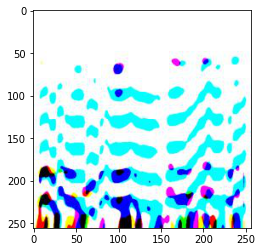

In [ ]:
Composit_Transformer = transforms.Compose([ToNumpy(), transforms.ToTensor()])

if Validation_Type == "Test and Train":

    Full_Dataset = Medical_Dataset(f"/content/{Root_Folder}", XTransformer=Composit_Transformer)

    Train_Size = int(len(Full_Dataset) * Train_Split)
    Test_Size = len(Full_Dataset) - Train_Size
    Train_Dataset, Test_Dataset = random_split(Full_Dataset, [Train_Size, Test_Size])

    Train_Loader = DataLoader(dataset=Train_Dataset, batch_size=Batch_Size, shuffle=True, pin_memory=True, num_workers=2)
    Test_Loader = DataLoader(dataset=Test_Dataset, batch_size=Test_Size, shuffle=True, pin_memory=True, num_workers=2)
    image, _ = Full_Dataset.__getitem__(0)

elif Validation_Type == "Leave One Out":

    Validation_Subject = 1
    Train_Dataset = Medical_Dataset(f"/content/{Root_Folder}", XTransformer=Composit_Transformer,  Validation_Type="LOO", 
                                    Train_Dataset=True, Validation_Subject=Validation_Subject)
    Test_Dataset = Medical_Dataset(f"/content/{Root_Folder}", XTransformer=Composit_Transformer,  Validation_Type="LOO", 
                                   Train_Dataset=False, Validation_Subject=Validation_Subject)

    Test_Size = len(Test_Dataset)

    Train_Loader = DataLoader(dataset=Train_Dataset, batch_size=Batch_Size, shuffle=True, pin_memory=True, num_workers=2)
    Test_Loader = DataLoader(dataset=Test_Dataset, batch_size=Test_Size, shuffle=True, pin_memory=True, num_workers=2)
    image, _ = Train_Dataset.__getitem__(0)
    image, _ = Test_Dataset.__getitem__(0)

else:

    raise ValueError("no Condition is choosed")

input_size = image.shape
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.show()

# Defining and Initializing the Model

In [ ]:
# Defining the Model
Model = CNN_Model(input_size, 2).to(Device)

# Initializing the Model
Model.apply(weight_initializer)

# Summary of the Model
Summary(Model, input_size=input_size, batch_size=Batch_Size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [75, 96, 125, 125]          14,208
              ReLU-2         [75, 96, 125, 125]               0
         MaxPool2d-3           [75, 96, 62, 62]               0
            Conv2d-4           [75, 32, 29, 29]          76,832
              ReLU-5           [75, 32, 29, 29]               0
           Dropout-6           [75, 32, 29, 29]               0
            Conv2d-7           [75, 16, 14, 14]           4,624
              ReLU-8           [75, 16, 14, 14]               0
         MaxPool2d-9             [75, 16, 7, 7]               0
           Conv2d-10              [75, 8, 3, 3]           1,160
             ReLU-11              [75, 8, 3, 3]               0
          Flatten-12                   [75, 72]               0
           Linear-13                   [75, 50]           3,650
             ReLU-14                   

# Defineing Loss Function and Optimizer

In [ ]:
# Defining Loss Function
Criteria = nn.CrossEntropyLoss()

# Defining Optimizer
Optimizer = optim.Adam(Model.parameters(), lr=Learning_Rate)

# Training the Model

In [ ]:
Total_Train_Accuracy = np.empty(0)
Total_Test_Accuracy = np.empty(0)

Total_Train_Loss = np.empty(0)
Total_Test_Loss = np.empty(0)

# Loop Through Epochs
for epoch in range(1, Epochs + 1):

    Unormalized_Train_Loss = 0
    Test_Loss = 0

    # Loop Through Bacthes
    for Batch_Number, (image, label) in enumerate(Train_Loader, 1):
        
        # Retrive the batch of image and labels from Dataset
        image = image.to(device=Device)
        label = label.to(device=Device)
        
        # zero the parameter gradient
        Optimizer.zero_grad()

        # Forward Step
        output = Model(image)
        
        # Backward Step
        Loss = Criteria(output, label)
        Loss.backward()

        # Opimization Step
        Optimizer.step()

        # Calculating the Loss in an epoch
        Unormalized_Train_Loss += Loss.item()

    Train_Loss = Unormalized_Train_Loss / Batch_Number
    Total_Train_Loss = np.append(Total_Train_Loss, Train_Loss)

    # Calculating the Test Loss
    with torch.no_grad():

        image , label = next(iter(Test_Loader))

        # # Transfer data to Device
        label = label.to(Device)
        image = image.to(Device)

        # Forward Propagation and Calculate the Loss
        output = Model(image)
        Loss = Criteria(output, label)

        # Calculating loss for all the Test Dataset
        Test_Loss += Loss.item()

    Total_Test_Loss = np.append(Total_Test_Loss, Test_Loss)

    Train_Accuracy =  Accuracy_Computer(Model, Train_Loader, Device)
    Test_Accuracy = Accuracy_Computer(Model, Test_Loader, Device)
    
    Total_Train_Accuracy = np.append(Total_Train_Accuracy, Train_Accuracy)
    Total_Test_Accuracy = np.append(Total_Test_Accuracy, Test_Accuracy)

    print(f"Epoch {epoch}/{Epochs} :\n {' ' * 5} "
          f"[Train Loss = {Train_Loss:.5f}] - [Train Accuracy = {(Train_Accuracy * 100):.2f}%] | "
          f"[Test Loss = {Test_Loss:.5f}] - [Test Accuracy = {(Test_Accuracy * 100):.2f}%] \n "
          f"{' ' * 4 + '-' * 110}")

Epoch 1/60 :
       [Train Loss = 0.68308] - [Train Accuracy = 61.49%] | [Test Loss = 0.66577] - [Test Accuracy = 60.61%] 
     --------------------------------------------------------------------------------------------------------------
Epoch 2/60 :
       [Train Loss = 0.64648] - [Train Accuracy = 64.29%] | [Test Loss = 0.63110] - [Test Accuracy = 65.34%] 
     --------------------------------------------------------------------------------------------------------------
Epoch 3/60 :
       [Train Loss = 0.62942] - [Train Accuracy = 67.02%] | [Test Loss = 0.61488] - [Test Accuracy = 67.99%] 
     --------------------------------------------------------------------------------------------------------------
Epoch 4/60 :
       [Train Loss = 0.62179] - [Train Accuracy = 64.73%] | [Test Loss = 0.61769] - [Test Accuracy = 67.23%] 
     --------------------------------------------------------------------------------------------------------------
Epoch 5/60 :
       [Train Loss = 0.61509] -

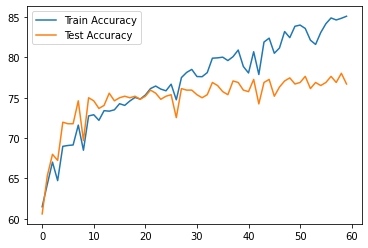

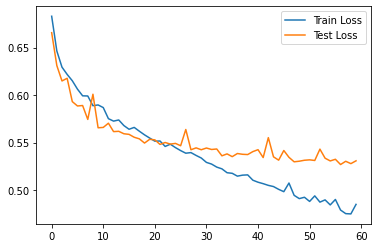

In [ ]:
plt.plot(Total_Train_Accuracy * 100)
plt.plot(Total_Test_Accuracy * 100)
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.show()

plt.plot(Total_Train_Loss)
plt.plot(Total_Test_Loss)
plt.legend(["Train Loss", "Test Loss"])
plt.show()